In [ ]:
!pip install torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd drive/MyDrive/Farhad\ Unibo

/content/drive/MyDrive/Farhad Unibo


In [ ]:
import os
import numpy as np
import cv2
import random
import keras.backend as K

from PIL import Image

from torch.utils.data import random_split
from torch.utils.data import Dataset, random_split

from keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def load_path(root_path = 'MURA-v1.1/valid/XR_ELBOW', size = 512): #given path is a placeholder data only
  '''
  load MURA dataset

  '''

  Path = []
  labels = []
  for root,dirs,files in os.walk(root_path): #Read all pictures, os.walk Return to iterator genertor Traverse all files
    for name in files:
      path_1 = os.path.join(root,name)
      Path.append(path_1)
      if root.split('_')[-1]=='positive':	 #positive Label is 1，otherwise 0；
        labels+=[1]   	          	 #Last level directory file patient11880\\study1_negative\\image3.png
      else:
          labels+=[0]
  print(len(Path))
  labels = np.asarray(labels)
  return Path, labels

def load_image(Path = 'MURA-v1.1/valid/XR_ELBOW', size = 512): #given path is a placeholder data only
	Images = []
	for path in Path:
		try:
			image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
			image = cv2.resize(image,(size,size))
			image = randome_rotation_flip(image,size)
			Images.append(image)

		except Exception as e:
			print(str(e))

	Images = np.asarray(Images).astype('float32')

	mean = np.mean(Images)			#normalization
	std = np.std(Images)
	Images = (Images - mean) / std

	if K.image_data_format() == "channels_first":
		Images = np.expand_dims(Images,axis=1)		   #Extended dimension 1
	if K.image_data_format() == "channels_last":
		Images = np.expand_dims(Images,axis=3)             #Extended dimension 3(usebackend tensorflow:aixs=3; theano:axixs=1)
	return Images


def randome_rotation_flip(image,size = 512):
	if random.randint(0,1):
		iamge = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

	if random.randint(0,1):
		angle = random.randint(-30,30)
		M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
		#The third parameter: the size of the transformed image
		image = cv2.warpAffine(image,M,(size,size))
	return image


In [ ]:
im_size = 320
X_train_path, Y_train = load_path(root_path = 'MURA-v1.1/train/XR_HUMERUS',size = im_size)
X_valid_path, Y_valid = load_path(root_path = 'MURA-v1.1/valid/XR_HUMERUS', size = im_size)

X_valid = load_image(X_valid_path,im_size)
Y_valid = np.asarray(Y_valid)
nb_classes = 1
img_dim = (im_size,im_size,1)

1272
288


In [ ]:
batch_size = 8  # earlier it was 64
nb_epoch = 150
depth = 6 * 3 + 4  # This parameter is no longer used, set directly from the list in the densenet 6*3+4
nb_dense_block = 4  # earlier it was 1
nb_filter = 16  # earlier it was 16
growth_rate = 12  # earlier it was 12
dropout_rate = 0.2
learning_rate = 1E-3  # earlier it was 1E-3
weight_decay = 1E-4
plot_architecture = False  # earlier it was False

In [ ]:
from tensorflow.keras import layers, Sequential
from keras.models import Model
from tensorflow.keras.optimizers import Adam

def attention_block(x, channels):
    avg_pool = layers.GlobalAveragePooling2D()(x)
    fc = Sequential([
        layers.Dense(channels // 4),
        layers.ReLU(),
        layers.Dense(channels),
        layers.Activation('sigmoid')
    ])(avg_pool)
    fc = layers.Reshape((1, 1, channels))(fc)
    return x * fc

def residual_block(x, in_channels, out_channels):
    identity = x
    x = layers.Conv2D(out_channels, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(out_channels, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = attention_block(x, out_channels)
    x += identity
    x = layers.ReLU()(x)
    return x

def make_layer(x, channels, blocks, stride=1):
    for _ in range(blocks):
        x = residual_block(x, channels, channels)
    return x

def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x = make_layer(x, 64, 3)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = Model([inputs], [outputs], name='resnet')
    return model

# Create an instance of the ResNet model
input_shape = (320, 320, 1)  # Update with your actual input shape
num_classes = 1# specify the number of classes
resnet_model = build_resnet(input_shape, num_classes)

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Compile the model
resnet_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

# Optionally, you can print the model summary to check the architecture and parameters
resnet_model.summary()


Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 160, 160, 64)         3136      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_7 (Bat  (None, 160, 160, 64)         256       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 re_lu_10 (ReLU)             (None, 160, 160, 64)         0         ['batch_normalization_7[0

In [ ]:
import datetime

if plot_architecture:
    from keras.utils import plot_model
    plot_model(model, to_file='./figures/densenet_archi.png', show_shapes=True)

####################
# Network training #
####################

print("Start Training")

list_train_loss = []
list_valid_loss = []
list_learning_rate = []
best_record = [100,0,100,100] #Recording optimal [verification set loss function value, accuracy rate, training set data set loss difference,acc difference]
start_time = datetime.datetime.now()
for e in range(nb_epoch):

    if e == int(0.25 * nb_epoch):
        K.set_value(resnet_model.optimizer.lr, np.float32(learning_rate / 10.))

    if e == int(0.5 * nb_epoch):
        K.set_value(resnet_model.optimizer.lr, np.float32(learning_rate / 50.))

    if e == int(0.75 * nb_epoch):
        K.set_value(resnet_model.optimizer.lr, np.float32(learning_rate / 100.))


    split_size = batch_size
    num_splits = len(X_train_path) / split_size

    arr_all = np.arange(len(X_train_path)).astype(int)
    random.shuffle(arr_all)                 #Randomly disrupted index order
    arr_splits = np.array_split(arr_all, num_splits)

    l_train_loss = []
    batch_train_loss = []
    start = datetime.datetime.now()

    for i,batch_idx in enumerate(arr_splits):


        X_batch_path,Y_batch = [],[]
        for idx in batch_idx:
            X_batch_path.append(X_train_path[idx])
            Y_batch.append(Y_train[idx])
        X_batch = load_image(Path = X_batch_path, size =im_size)
        Y_batch = np.asarray(Y_batch)
        train_logloss, train_acc = resnet_model.train_on_batch(X_batch, Y_batch)

        l_train_loss.append([train_logloss, train_acc])
        batch_train_loss.append([train_logloss, train_acc])
        if i %100 == 0:
            loss_1, acc_1 = np.mean(np.array(l_train_loss), 0)
            loss_2, acc_2 = np.mean(np.array(batch_train_loss), 0)
            batch_train_loss = []           #Current 100 batch loss function and accuracy
            print ('[Epoch {}/{}] [Batch {}/{}] [Time: {}] [all_batchs--> train_epoch_logloss: {:.5f}, train_epoch_acc:{:.5f}] '.format(e+1,nb_epoch,i, len(arr_splits),datetime.datetime.now() - start,loss_1,acc_1), '[this_100_batchs-->train_batchs_logloss: {:.5f}, train_batchs_acc:{:.5f}]'.format(loss_2, acc_2))

    # Run verification set
    valid_logloss, valid_acc = resnet_model.evaluate(X_valid, Y_valid, verbose=0, batch_size=64)
    list_train_loss.append(np.mean(np.array(l_train_loss), 0).tolist())
    list_valid_loss.append([valid_logloss, valid_acc])
    list_learning_rate.append(float(K.get_value(resnet_model.optimizer.lr)))
    # to convert numpy array to json serializable
    print('[Epoch %s/%s] [Time: %s, Total_time: %s]' % (e + 1, nb_epoch, datetime.datetime.now() - start, datetime.datetime.now() - start_time),end = '')
    print('[train_loss_and_acc:{:.5f} {:.5f}] [valid_loss_acc:{:.5f} {:.5f}]'.format(list_train_loss[-1][0], list_train_loss[-1][1],list_valid_loss[-1][0],list_valid_loss[-1][1]))


    d_log = {}
    d_log["batch_size"] = batch_size
    d_log["nb_epoch"] = nb_epoch
    d_log["optimizer"] = opt.get_config()
    d_log["train_loss"] = list_train_loss
    d_log["valid_loss"] = list_valid_loss
    d_log["learning_rate"] = list_learning_rate

    record = [valid_logloss,valid_acc,abs(valid_logloss-list_train_loss[-1][0]),abs(valid_acc-list_train_loss[-1][1]),]
    if ((record[0]<=best_record[0]) &(record[1]>=best_record[1])) :
        if e <= int(0.25 * nb_epoch)|(record[2]<=best_record[2])&(record[3]<=best_record[3]):#Add a difference judgment after a quarter epoch
            best_record=record                      #Record the smallest [validation set loss function value, accuracy rate, training set data loss difference, acc difference]
            print('saving the best model:epoch',e+1,best_record)
            resnet_model.save('save_models/best_MURA_modle@epochs{}.h5'.format(e+1))
    resnet_model.save('save_models/MURA_modle@epochs{}.h5'.format(e+1))

Start Training
[Epoch 1/150] [Batch 0/159] [Time: 0:00:08.130112] [all_batchs--> train_epoch_logloss: 1.10823, train_epoch_acc:0.37500]  [this_100_batchs-->train_batchs_logloss: 1.10823, train_batchs_acc:0.37500]
[Epoch 1/150] [Batch 100/159] [Time: 0:08:03.613406] [all_batchs--> train_epoch_logloss: 0.71354, train_epoch_acc:0.55322]  [this_100_batchs-->train_batchs_logloss: 0.70960, train_batchs_acc:0.55500]
[Epoch 1/150] [Time: 0:12:44.599960, Total_time: 0:12:44.602893][train_loss_and_acc:0.70635 0.55267] [valid_loss_acc:0.69266 0.54861]
saving the best model:epoch 1 [0.6926600933074951, 0.5486111044883728, 0.013692182190013336, 0.004061851486469981]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[Epoch 2/150] [Batch 0/159] [Time: 0:00:00.168572] [all_batchs--> train_epoch_logloss: 0.63698, train_epoch_acc:0.75000]  [this_100_batchs-->train_batchs_logloss: 0.63698, train_batchs_acc:0.75000]
[Epoch 2/150] [Batch 100/159] [Time: 0:00:14.034496] [all_batchs--> train_epoch_logloss: 0.68870, train_epoch_acc:0.55941]  [this_100_batchs-->train_batchs_logloss: 0.68921, train_batchs_acc:0.55750]
[Epoch 2/150] [Time: 0:00:23.195787, Total_time: 0:13:09.535298][train_loss_and_acc:0.68854 0.56918] [valid_loss_acc:0.72560 0.46875]
[Epoch 3/150] [Batch 0/159] [Time: 0:00:00.184936] [all_batchs--> train_epoch_logloss: 0.66903, train_epoch_acc:0.62500]  [this_100_batchs-->train_batchs_logloss: 0.66903, train_batchs_acc:0.62500]
[Epoch 3/150] [Batch 100/159] [Time: 0:00:13.297716] [all_batchs--> train_epoch_logloss: 0.67064, train_epoch_acc:0.59035]  [this_100_batchs-->train_batchs_logloss: 0.67066, train_batchs_acc:0.59000]
[Epoch 3/150] [Time: 0:00:22.532374, Total_time: 0:13:33.094205][train

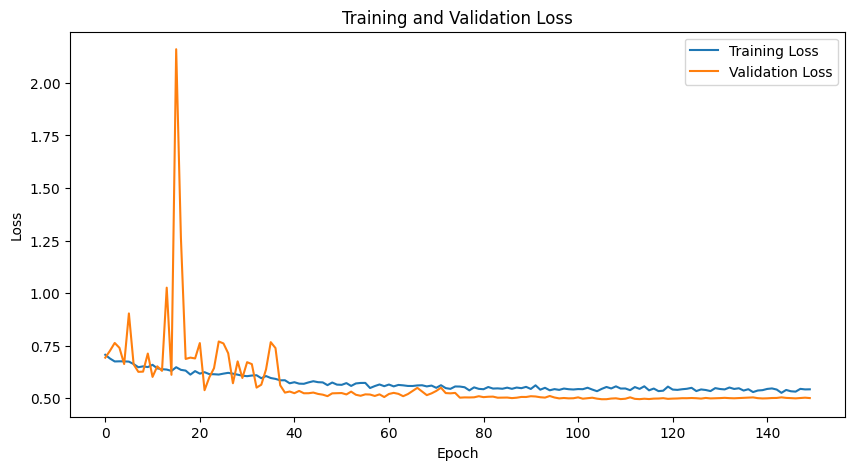

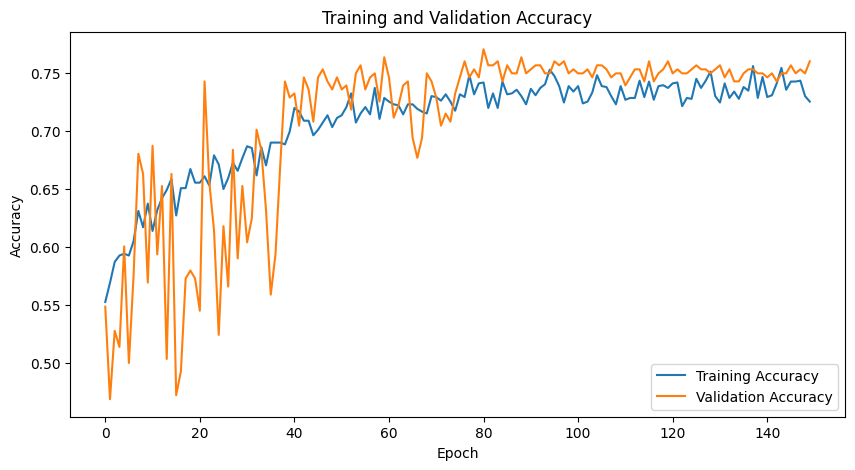

9/9 [==============================] - 1s 47ms/step


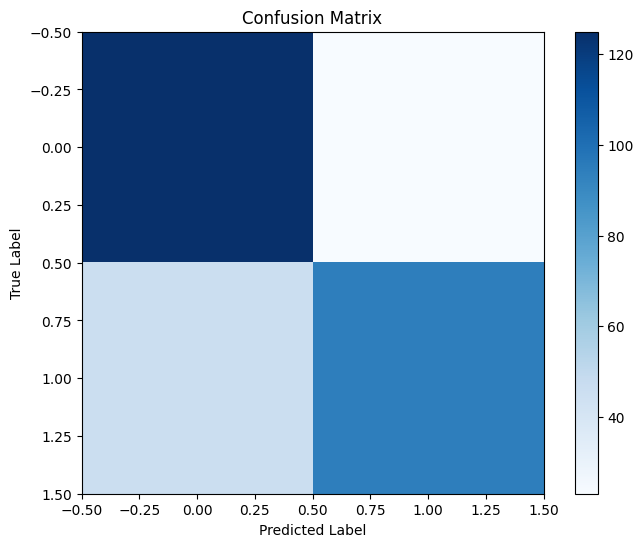

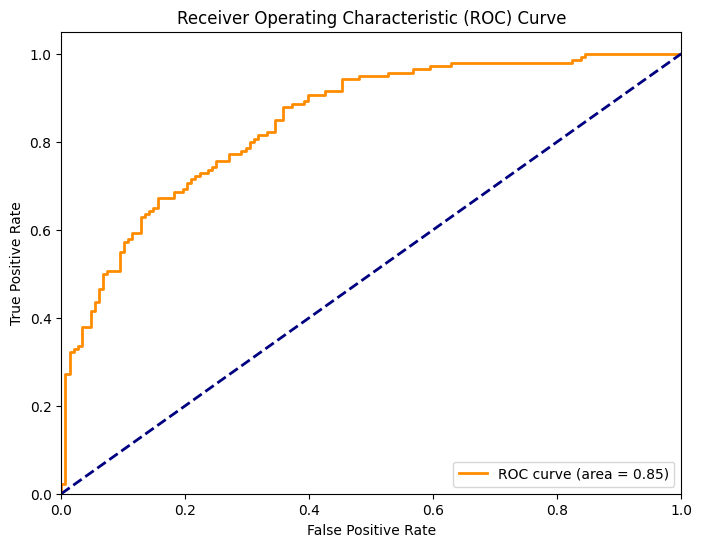

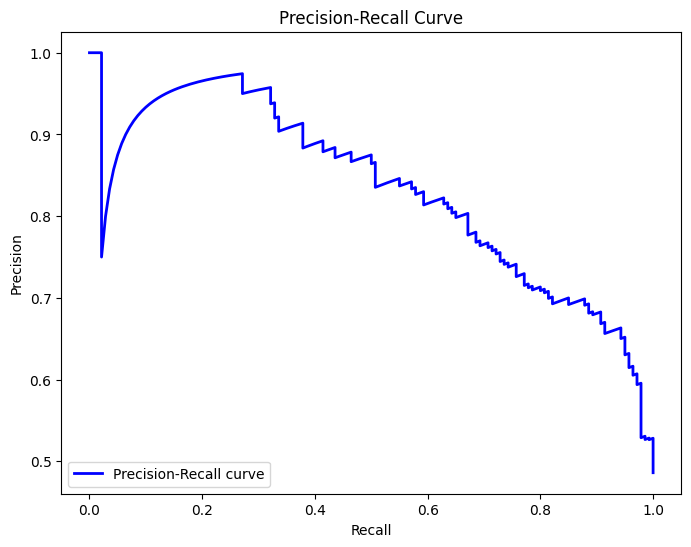

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

# Plot training and validation loss
train_loss = [item[0] for item in list_train_loss]
valid_loss = [item[0] for item in list_valid_loss]

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
train_acc = [item[1] for item in list_train_loss]
valid_acc = [item[1] for item in list_valid_loss]

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Display confusion matrix
# Assuming predictions are in 'y_pred' and true labels are in 'Y_valid'
y_pred = resnet_model.predict(X_valid)
y_pred_binary = (y_pred > 0.5).astype(int)
conf_mat = confusion_matrix(Y_valid, y_pred_binary)

plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(Y_valid, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(Y_valid, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


In [ ]:

# Calculate final evaluation metrics
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(Y_valid, y_pred_binary)
precision = precision_score(Y_valid, y_pred_binary)
recall = recall_score(Y_valid, y_pred_binary)
f1 = f1_score(Y_valid, y_pred_binary)

print("Final Evaluation Results:")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-Score: {:.4f}".format(f1))
print("AUC: {:.4f}".format(roc_auc))


Final Evaluation Results:
Accuracy: 0.7604
Precision: 0.8034
Recall: 0.6714
F1-Score: 0.7315
AUC: 0.8458
